In [2]:
import pandas as pd
import dvc.api
from tqdm import tqdm

In [3]:
from copy import deepcopy
import hashlib
from collections import OrderedDict
import json
def sortOD(od):
    res = OrderedDict()
    for k, v in sorted(od.items()):
        if isinstance(v, dict):
            res[k] = sortOD(v)
        else:
            res[k] = deepcopy(v)
    return res

In [4]:
df_metadata = pd.read_csv('../../../attribute_extraction_metadata_template/Initial Attribute Definition for First Release - UPDATED SHEET .csv')

In [5]:
df_metadata = df_metadata[['category', 'category_id', 'attribute_field', 'category_attributevalue', 'description', 'max_multi_select', 'usage', 'entry mode']]

In [6]:
metadata_category = set(df_metadata.category)
metadata_category_ids = set(df_metadata.category_id)

In [7]:
category2config = {}
for i in metadata_category:
    df_tmp = df_metadata[df_metadata.category == i]
    category2config[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])
categoryid2config = {}
for i in metadata_category_ids:
    df_tmp = df_metadata[df_metadata.category_id == i]
    categoryid2config[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])

In [8]:
# extract all attributes
category2config_multiselect = {}
for i in tqdm(metadata_category):
    df_tmp = df_metadata[df_metadata.category == i].copy()
    df_tmp['entry mode'] = df_tmp['entry mode'].replace({'single_selection_only': 'multi_selection_only'})
    df_tmp.loc[(df_tmp['entry mode'] == 'multi_selection_only'), "max_multi_select"] = 100.0
    category2config_multiselect[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])
categoryid2config_multiselect = {}
for i in tqdm(metadata_category_ids):
    df_tmp = df_metadata[df_metadata.category_id == i].copy()
    df_tmp['entry mode'] = df_tmp['entry mode'].replace({'single_selection_only': 'multi_selection_only'})
    df_tmp.loc[(df_tmp['entry mode'] == 'multi_selection_only'), "max_multi_select"] = 100.0
    categoryid2config_multiselect[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])

100%|██████████| 2658/2658 [00:05<00:00, 466.27it/s]


In [7]:
df_tax = pd.read_json(dvc.api.get_url(
    'datasets/data/taxonomy/wish_newtax.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [8]:
tax2id = {}
for i in df_tax.to_dict('records'):
    if len(i['category_path']) > 0:
        tax2id[i['category_path']] = int(i['id'])

# 1st preloading production batch

In [9]:
df = pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/2023q2tli_product_attribute_extraction/product_attribute_extraction_2023q2tli_041723_validprompt_041823_sample_041823_oaiinfer_041823_nonan_041823_parsed_041823.json', 
                  lines=True)

In [10]:
len(df)

11328

In [12]:
del df['index']

In [13]:
df.head(1)

,product_id,category_id,category_path,title,description,color,size,prompt,oai_response,oai_response_parsed
0,618f9295734591e8ffdbf281,1245,Cellphones & Telecommunications > Cellphones,11T Pro 2022 new 5G Android smartphone ten-cor...,"Factory direct sales, high quality and low pri...","[white, Black, black]","[UK Plug 16GB&1TB, EU Plug 16GB&1TB, AU Plug 1...","{'model': 'gpt-3.5-turbo', 'messages': [{'role...",{'id': 'chatcmpl-76gnBFxjmHffpuyGHX2IbgRr8ve9U...,"{'Aspect Ratio': [], 'Brand': [], 'Camera Reso..."


<Axes: ylabel='category_path'>

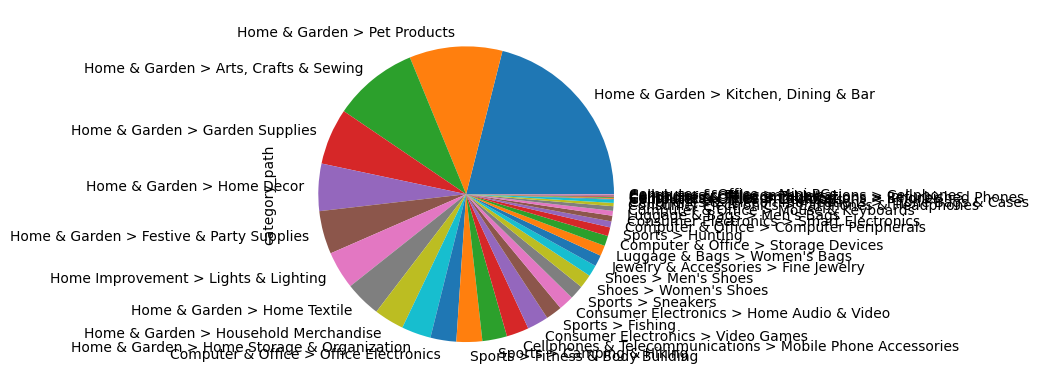

In [14]:
df.category_path.apply(lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

In [15]:
df['product_description'] = df['description']
df['main_image_url'] = None

In [18]:
set(df)

{'category_id',
 'category_path',
 'color',
 'description',
 'main_image_url',
 'oai_response',
 'oai_response_parsed',
 'product_description',
 'product_id',
 'prompt',
 'size',
 'title'}

In [19]:
df = df[~df['oai_response_parsed'].isna()]

In [20]:
len(df)

11163

In [39]:
res = []
for i in tqdm(df[['product_id', 'category_id', 'category_path', 'title', 
                  'product_description', 'main_image_url', 'oai_response_parsed']].to_dict('records')):
    i['text'] = \
f"""Title: {i['title']}
Description: {i['product_description']}"""
    i['attribute_config'] = categoryid2config_multiselect[i['category_id']]
    d = i['oai_response_parsed']
    ad = {j['attribute_field']: eval(j['category_attributevalue']) for j in i['attribute_config']}
    nd = {}
    for k in d:
        if k in ad:
            nd[k] = []
            for j in d[k]: 
                for f in ad[k]:
                    if str(f).lower().strip() == str(j).lower().strip():
                        nd[k].append(f)
                        break
        else:
            nd[k] = []
    i['preloading_result'] = nd
    task_json = json.dumps(sortOD(i)).encode('utf-8')
    task_id = hashlib.md5(task_json).hexdigest()
    i['task_id'] = f"product_attribution_md_preload_{task_id}"
    res.append(i)

100%|██████████| 11163/11163 [00:21<00:00, 524.89it/s]


In [40]:
pd.DataFrame(res).to_json('input_preload/product_attr_extract_md_oaipreload_04182023.json', lines=True, orient='records')

In [41]:
len(res)

11163

In [42]:
len(set([i['task_id'] for i in res]))

11163

In [43]:
df_res = pd.DataFrame(res)

In [48]:
df_res[['title', 'product_description', 'oai_response_parsed', 'preloading_result']].sample(2).to_dict('records')

[{'title': '12Pcs Exquisite High-End Hotel Restaurant Dedicated Flower Design Napkin Ring Mouth Cloth Napkin Ring',
  'product_description': "- Color: Black;Silver;Gold ;Rose Gold;Red;Orange\r\n- Material: Alloy.\r\n- Size: Approx.5.2*5.2*5.0CM\r\n- High quality with comfortable touch.\r\n- Elegant and exquisite flower design.\r\n- Suitable for a wedding or family reunion.\r\n- Nice embellishment for napkin, simple and practical.\r\n- Makes napkin natural and beautiful and gives you a nice mood.\r\n- Note: Please be reminded that due to lighting effects and monitor's brightness/contrast settings etc, the color tone of the website's photo and the actual item could be slightly different.\r\n\r\nPackage including:\r\n12 x napkin ring",
  'oai_response_parsed': {'Alpha Size': [],
   'Brand Name': [],
   'Care Instructions': [],
   'Finish': [],
   'Is Dishwasher Safe': [],
   'Item Features': ['High quality with comfortable touch',
    'Elegant and exquisite flower design',
    'Nice embel

In [49]:
df_res['oai_response_parsed'].apply(lambda x: sum([len(x[i]) for i in x]) / len(x))

0        0.608696
1        1.043478
2        1.434783
3        0.608696
4        0.391304
           ...   
11158    0.482759
11159    0.793103
11160    0.206897
11161    0.586207
11162    0.551724
Name: oai_response_parsed, Length: 11163, dtype: float64

In [50]:
df_res['preloading_result'].apply(lambda x: sum([len(x[i]) for i in x]) / len(x))

0        0.043478
1        0.173913
2        0.260870
3        0.130435
4        0.043478
           ...   
11158    0.034483
11159    0.172414
11160    0.068966
11161    0.068966
11162    0.000000
Name: preloading_result, Length: 11163, dtype: float64